In [1]:
import os
import pandas as pd
from IPython.display import display
import numpy as np
import tensorflow as tf
from tensorflow import keras
import sklearn
from matplotlib import pyplot as plt
import joblib
import pickle 

from MyTransformers import *
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.special import inv_boxcox
import seaborn as sns

#%config Completer.use_jedi = False
%matplotlib inline  

f_data_path = "PrepedData/"
f_modele_path = 'Model/'

f_HHData = f_data_path + 'HHDataId/'
mode_path = "Models/"

In [2]:
def rmspe(y_true, y_pred):
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))
    return loss

def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [255]:
def AgregateDiffs(xdiff, start=0):
    return (xdiff.cumsum() + start)
n=48
def plot_series(series, y=None, y_pred=None, _n=n, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(_n, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(_n, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    #plt.hlines(0, 0, 100, linewidth=1)
    #plt.axis([0, _n + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

def plot_multiple_forecasts(X, Y, Y_pred, _n=n, toAgregate=False):
    n_steps = len(X)
    ahead = len(Y)
    # if toAgregate:
    #     X = AgregateDiffs(X).reshape(-1,n_steps,1)
    #     Y = AgregateDiffs(Y,X[:,-1]).reshape(-1,ahead,1)
    #     Y_pred = AgregateDiffs(Y_pred,X[:,-1]).reshape(-1,ahead,1)

    # plot_series(X[0, :, 0],_n=n)
    # plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    # plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plot_series(X,_n=n)
    plt.plot(np.arange(n_steps, n_steps + ahead), Y, "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred, "rx-", label="Forecast", markersize=10)

    #plt.axis([0, n_steps + ahead, X.min(), X.max()])
    plt.legend(fontsize=14)

def BatchWithNLen(n,pred_n,time_series, other_data=[],TVT_slit=(0.7,0.9)):
    if len(time_series) % n != 0:
        time_series = time_series[:len(time_series) - (len(time_series) % n)]

    dim = 1 if time_series.ndim == 1 else time_series.shape[-1]
    time_series = time_series.reshape(-1,n,dim)
    l = len(time_series)
    X_train = time_series[:int(l*TVT_slit[0])                  , :n-pred_n, 0].reshape(-1,n-pred_n,1)
    X_valid = time_series[int(l*TVT_slit[0]):int(l*TVT_slit[1]), :n-pred_n, 0].reshape(-1,n-pred_n,1) 
    X_test  = time_series[int(l*TVT_slit[1]):                  , :n-pred_n, 0].reshape(-1,n-pred_n,1)
    y_train = time_series[:int(l*TVT_slit[0])                  , -pred_n:, 0].reshape(-1,pred_n,1)
    y_valid = time_series[int(l*TVT_slit[0]):int(l*TVT_slit[1]), -pred_n:, 0].reshape(-1,pred_n,1)
    y_test  = time_series[int(l*TVT_slit[1]):                  , -pred_n:, 0].reshape(-1,pred_n,1)
    if len(other_data) > 0:
        if len(other_data) % n != 0:
           other_data = other_data[:len(other_data) - (len(other_data) % n)]

        dim = 1 if other_data.ndim == 1 else other_data.shape[-1]
        other_data = other_data.reshape(-1,n,dim)
        X_other_train = other_data[:int(l*TVT_slit[0])                  , -pred_n, :]
        X_other_valid = other_data[int(l*TVT_slit[0]):int(l*TVT_slit[1]), -pred_n, :]
        X_other_test  = other_data[int(l*TVT_slit[1]):                  , -pred_n, :]
        return (X_train, y_train, X_other_train), (X_valid, y_valid, X_other_valid) , (X_test, y_test, X_other_test)
    return (X_train, y_train), (X_valid, y_valid) , (X_test, y_test)
    
def OverlapingBatchWithNLen(n,pred_n,time_series, other_data=[],TVT_slit=(0.7,0.9)):
    if len(time_series) % n != 0:
        time_series = time_series[:len(time_series) - (len(time_series) % n)]

    dim = 1 if time_series.ndim == 1 else time_series.shape[-1]
    time_series = time_series.reshape(-1,n,dim)
    l = len(time_series)
    X_train = time_series[:int(l*TVT_slit[0])                  , :n-pred_n, 0].reshape(-1,n-pred_n,1)
    X_valid = time_series[int(l*TVT_slit[0]):int(l*TVT_slit[1]), :n-pred_n, 0].reshape(-1,n-pred_n,1) 
    X_test  = time_series[int(l*TVT_slit[1]):                  , :n-pred_n, 0].reshape(-1,n-pred_n,1)

    Y = np.empty((l, n-pred_n, pred_n))
    for step_ahead in range(1, pred_n + 1):
        Y[..., step_ahead - 1] = time_series[..., step_ahead:step_ahead + n - pred_n, 0]    
        
    y_train = Y[:int(l*TVT_slit[0])                  ]
    y_valid = Y[int(l*TVT_slit[0]):int(l*TVT_slit[1])]
    y_test  = Y[int(l*TVT_slit[1]):                  ]
    
    if len(other_data) > 0:
        if len(other_data) % n != 0:
           other_data = other_data[:len(other_data) - (len(other_data) % n)]

        dim = 1 if other_data.ndim == 1 else other_data.shape[-1]
        other_data = other_data.reshape(-1,n,dim)
        # X_other = np.empty((l, n-n_feature,n_feature, len(other_features)))
        # for step_ahead in range(1, pred_n + 1):
            # X_other[..., step_ahead - 1, :] = b[..., step_ahead:step_ahead + n - n_feature, 1:]
        # X_other_train = X_other[:int(l*0.7)           , ...]
        # X_other_valid = X_other[int(l*0.7):int(l*0.9) , ...]
        # X_other_test  = X_other[int(l*0.9):           , ...]

        X_other_train = other_data[:int(l*TVT_slit[0])                  , pred_n:n, :]
        X_other_valid = other_data[int(l*TVT_slit[0]):int(l*TVT_slit[1]), pred_n:n, :]
        X_other_test  = other_data[int(l*TVT_slit[1]):                  , pred_n:n, :]
        return (X_train, y_train, X_other_train), (X_valid, y_valid, X_other_valid) , (X_test, y_test, X_other_test)
    return (X_train, y_train), (X_valid, y_valid) , (X_test, y_test)
    
class MyLoader:
    def __init__(self,files,batchSize,timeSeriesLables, otherDataLabels,splitFun, sumInN = 1, asDiff = False, asSum = False, asBoxcox=False,
                TVT_split=(0.7,0.9),diffLags=[1],pred_n = 10,lable="default"):
        self.batchSize = batchSize
        self.timeSeriesLables = timeSeriesLables
        self.otherDataLabels = otherDataLabels
        self.sumInN = sumInN
        self.asDiff = asDiff
        self.asSum = asSum
        self.asBoxcox = asBoxcox
        self.files = files
        self.TVT_split = TVT_split
        self.diffLags = diffLags
        self.pred_n = pred_n
        self.splitFun = splitFun
        self.lable = lable

    def loadDataTimeSeries(self, files):
        tmpArr = [[]]*len(files)
        dataOut = np.empty((0,len(self.timeSeriesLables)))
        for i,file in enumerate(files):
            progres_bar(i + 1,len(files))
            data = pd.read_feather(file)
            data = data[self.timeSeriesLables].values
            if self.asSum:
                data = data[:len(data) - (len(data) % self.sumInN)]
                if len(self.timeSeriesLables) > 1:
                    data = data.reshape(-1,self.sumInN,len(self.timeSeriesLables))     
                else:
                    data = data.reshape(-1,self.sumInN)
                data = data.sum(axis=1,keepdims=True)

            if self.asBoxcox:
                data , self.boxcoxLambda = stats.boxcox(data.flatten())
                data = data.reshape(-1,1)

            if self.asDiff:
                self.diffInitVals = []
                self.diffYInitVals = []
                for lag in self.diffLags:
                    tmp = data[:len(data) - len(data)%self.batchSize].reshape(-1,self.batchSize)
                    self.diffInitVals.append (tmp[:,-lag:].reshape(-1,lag))
                    self.diffYInitVals.append(tmp[1:,self.batchSize-self.pred_n -lag:self.batchSize-self.pred_n].reshape(-1,lag))
                    data = data[lag:] - data[:-lag]
                    data = data[self.batchSize - lag:]
                #data = data[1:]

            tmpArr[i] = data[:len(data) - (len(data) % self.batchSize)]
        if len(files) > 0:    
            dataOut = np.row_stack(tmpArr)
        else:
            dataOut = tmpArr[0]
        return dataOut.astype('f4')

    def loadDataOther(files, features, batchSize):
        tmpArr = [[]]*len(files)
        dataOut = np.empty((0,len(features)))
        for i,file in enumerate(files):
            progres_bar(i + 1,len(files))
            data = pd.read_feather(file)
            data = data[features].values
            tmpArr[i] = data[:len(data) - (len(data) % batchSize)]
        if len(files) > 0:    
            dataOut = np.row_stack(tmpArr)
        else:
            dataOut = tmpArr[0]
        return dataOut.astype('f4')

    def load(self):
        self.timeSeries = self.loadDataTimeSeries(self.files)
        if self.hasOther():
            self.otherData = MyLoader.loadDataOther(self.files, self.otherDataLabels, self.batchSize)
            (self.XTrain, self.YTrain, self.XOtherTrain), (self.XValid, self.YValid, self.XOtherValid), (self.XTest, self.YTest, self.XOtherTest) = self.splitFun(self.batchSize,self.pred_n,self.timeSeries, self.otherData, self.TVT_split)
        else:
            (self.XTrain, self.YTrain), (self.XValid, self.YValid), (self.XTest, self.YTest) = self.splitFun(self.batchSize,self.pred_n,self.timeSeries, [], self.TVT_split)
        # if self.asDiff:
        #     self.diffInitVals = []
        #     for i,batch in enumerate(self.XTest):
        #         tmpLags = []
        #         for lag in self.diffLags:
        #             tmpLags.append(batch[:lag].flatten())
        #             self.XTest[i] = batch[lag:] - batch[:-lag]
        #         self.diffInitVals.append(tmpLags)
        #     self.diffYInitVals = []
        #     for i,batch in enumerate(self.YTest):
        #         tmpLags = []
        #         for lag in self.diffLags:
        #             tmpLags.append(batch[:lag].flatten())
        #             self.YTest[i] = batch[lag:] - batch[:-lag]
        #         self.diffYInitVals.append(tmpLags)


    def hasOther(self):
        return True if self.otherDataLabels else False
    
    def setArgs(self,args):
        self.args = args
    
    def diffInvers(self,arr,isXInitVals=True, batchNum = 0):
        if isXInitVals: InitVals = self.diffInitVals
        else: InitVals = self.diffYInitVals
        # print(batchNum)
        # print("initvals shape:",len(InitVals), InitVals[0].shape)
        # print("diflag:",self.diffLags)
        # cumLag = 0
        # if isXInitVals:
        #     self.diffYInitVals = []
        j = 0
        for k,lag in reversed(list(enumerate(self.diffLags))):
            cc = np.empty(len(arr)+lag)
            # print("lag:",lag)
            # print(k, InitVals[k][batchNum]) 
            for i in range(lag): 
                # print(k,i, InitVals[k][batchNum][i]) 
                cc[i::lag] = np.cumsum(np.concatenate([[InitVals[k][batchNum+j][i]],arr[i::lag]]))  
            arr = cc[lag:]
            j += 1
            # if isXInitVals:
            #     self.diffYInitVals.append(cc[-lag :])
            #     # self.diffYInitVals.append(cc[-lag - cumLag : len(cc)-cumLag])
            #     #cumLag += lag
        return arr

class MyModel:
    _model = None
    _lableDefined = False
    _dataLoaded = False
    _trainingStarted = False
    _epoch = 0
    def __init__(self, batchSize, loader,lable,createModel,modelArgs,modleDims,predDataFun):
        self.batchSize = batchSize
        self.loader = loader
        self._lable = lable
        self.createModel = createModel
        self.modelArgs = modelArgs
        self.modleDims = modleDims
        self.predDataFun = predDataFun

    def load(self):
        if not self._dataLoaded:
            self.loader.load() 
            self._dataLoaded = True
        
    def model(self):
        if self._model == None:
            dim = 1 if self.loader.timeSeries.ndim == 1 else self.loader.timeSeries.shape[-1]
            if self.loader.hasOther():
                dim = [dim, 1 if self.loader.otherData.ndim == 1 else self.loader.otherData.shape[-1]]
            self.loader.setArgs(self.modelArgs)
            self._model = self.createModel(self.batchSize,dim,self.modelArgs, self.modleDims)
        return self._model

    def lable(self):
        if not self._lableDefined:
            for i in range(len(self.modleDims)):
                self._lable += f"-{self.modleDims[i]}" 
            self._lable += '-Batch-'+ str(self.batchSize)
            self._lableDefined = True
        return self._lable

    def prepModel(self, loss='mse', optimizer='adam', learningRate=0.01):
        if optimizer == 'adam':
            opt = keras.optimizers.Adam(learning_rate=learningRate)
        self.model().compile(loss=loss, optimizer=opt)
        self.tbCallBack = keras.callbacks.TensorBoard(log_dir=f'./Graph/{self.loader.lable}/n{self.batchSize}/{optimizer}-LeRate-{learningRate}-loss-{loss}/{self.lable()}', histogram_freq=0, write_graph=True, write_images=True)
        self.earlyStopCallback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20,min_delta=0, restore_best_weights=True)

    def train(self,epochs,loss='mse', optimizer='adam', learningRate=0.01, batch_size=4, isEarlyStoping=True, isSaveTensorBoard=True,**kwargs):
        if not self._trainingStarted:
            self.load()
            self.prepModel(loss,optimizer,learningRate)
            self.history = []
            self.trainData , self.validData, self.testData = self.predDataFun(self.loader)
            self._trainingStarted = True

        callbacks = []
        if isSaveTensorBoard: callbacks.append(self.tbCallBack)
        if isEarlyStoping: callbacks.append(self.earlyStopCallback) 

        self.history.append(self.model().fit(self.trainData[0], self.trainData[1], epochs=epochs,batch_size=batch_size,
        validation_data=self.validData,callbacks=callbacks,**kwargs))
        print("Done Fiting.")
        self._epoch += epochs
      
    def test(self,plotsCount=5,batchStart=1,random=False):
        batchs = range(batchStart,batchStart + plotsCount)
        if random:
            batchs = np.round(np.random.rand(plotsCount) * (len(self.testData[1])-1)).astype('i4')
        for batch in batchs:
            print(batch)
            if self.loader.hasOther():
                X_new = [[]]*len(self.testData[0])
                for i,vec in enumerate(self.testData[0]):
                    X_new[i] = vec[batch:batch+1]
            else:
                X_new = self.testData[0][0][batch:batch+1]

            Y_new = self.testData[1][batch:batch+1]
            if self.loader.splitFun == OverlapingBatchWithNLen:
                # Y_pred = self.model().predict(X_new)[:, -self.loader.pred_n:]
                # Y_new = Y_new[:, -self.loader.pred_n:]
                Y_pred = self.model().predict(X_new)[0, -1,:]
                Y_new = Y_new[0, -1,:]
            elif self.loader.splitFun == BatchWithNLen:
                Y_pred = self.model().predict(X_new).reshape(1,self.loader.pred_n,1)
            else: print("what")

            if self.loader.hasOther():
                X = X_new[0]
            else:
                X = X_new
            
            if self.loader.asBoxcox:
                X = inv_boxcox(X,self.loader.boxcoxLambda)
                Y_new = inv_boxcox(Y_new,self.loader.boxcoxLambda)
                Y_pred = inv_boxcox(Y_pred,self.loader.boxcoxLambda)
            
            X = X[0,:,0]
            #Y_new = Y_new[0,:,0]
           # Y_pred = Y_pred[0,:,0]
           # print("plot shapes:",X.shape,Y_new.shape,Y_pred.shape)
            if self.loader.asDiff:
                X = self.loader.diffInvers(X,True,batch + len(self.loader.XTrain) + len(self.loader.XValid))
                Y_new = self.loader.diffInvers(Y_new,False,batch + len(self.loader.XTrain) + len(self.loader.XValid))
                Y_pred = self.loader.diffInvers(Y_pred,False,batch + len(self.loader.XTrain) + len(self.loader.XValid))

            plot_multiple_forecasts(X, Y_new, Y_pred,_n=self.batchSize)
            plt.figure()

    def save(self):
        self.model().save(mode_path + f'{self.lable()}-epoch-{self._epoch}')

    def testResult(self, show=False):
        l = len(self.testData[1])
        l_pSum = np.zeros(l); l_ySum = np.zeros(l); l_diff = np.zeros(l); l_prec = np.zeros(l); l_mse = np.zeros(l)
        l_rmspe = np.zeros(l); l_mape = np.zeros(l)
        #pSize = self.loader.pred_n + (0 if not self.loader.asDiff else np.sum(self.loader.diffLags)) 
        pSize = self.loader.pred_n
        l_Y = np.zeros((l,pSize)); l_pred = np.zeros((l,pSize))
        for j in range(l):
            if self.loader.hasOther():
                X = [[]]*len(self.testData[0])
                for i,vec in enumerate(self.testData[0]):
                    X[i] = vec[j:j+1]
            else:
                X = self.testData[0][0][j:j+1]
            Y = self.testData[1][j:j+1]

            if self.loader.splitFun == OverlapingBatchWithNLen:
                pred = self.model().predict(X)[0, -1,:]#.reshape(self.loader.pred_n)
                Y = Y[-1,-1]
            elif self.loader.splitFun == BatchWithNLen:
                pred = self.model().predict(X).reshape(self.loader.pred_n)
                Y = Y.reshape(self.loader.pred_n)
            else: 
                print("what")
                print(self.loader.splitFun,OverlapingBatchWithNLen,BatchWithNLen)
            if self.loader.asDiff:
                #X = self.loader.diffInvers(X[0,:,0],True,j + len(self.loader.XTrain) + len(self.loader.XValid))
                pred = self.loader.diffInvers(pred,False,j + len(self.loader.XTrain) + len(self.loader.XValid))
                Y = self.loader.diffInvers(Y,False,j + len(self.loader.XTrain) + len(self.loader.XValid))
            if self.loader.asBoxcox:
                pred = inv_boxcox(pred,self.loader.boxcoxLambda)
                Y = inv_boxcox(Y,self.loader.boxcoxLambda)
            l_pSum[j] = pred.sum()
            l_ySum[j] = Y.sum()
            l_diff[j] = l_ySum[j] - l_pSum[j]
            l_prec[j] = ((l_diff[j] / l_ySum[j]) * 100)
            l_mse[j] = (mean_squared_error(Y,pred))
            l_rmspe[j] = rmspe(Y,pred)
            l_mape[j] = mape(Y,pred)
            l_Y[j] = Y
            l_pred[j] = pred.copy()
            if show:
                print(f"predSum: {l_pSum[j]: .4f} YSum: {l_ySum[j]: .4f} diff: {l_diff[j]: .4f} precent: {l_prec[j]: .4f}% \t mse: {l_mse[j]: .4f} rmspe: {l_rmspe[j]: .4f} mape: {l_mape[j]: .4f}") 
        return l_pSum, l_ySum, l_diff, l_prec, l_mse, l_rmspe, l_mape, l_Y, l_pred


In [5]:
LPG = MyLoader(
    files=[f_data_path + "LPG-Profile-0.feather"],
    batchSize=48,
    timeSeriesLables=['energy'],
    otherDataLabels=[],
    splitFun=BatchWithNLen,
    sumInN=60*3,
    asSum=True,
    pred_n=1,
    lable="LPG")

LPG10 = MyLoader(
    files=[f_data_path + "LPG-Profile-0.feather"],
    batchSize=48,
    timeSeriesLables=['energy'],
    otherDataLabels=[],
    splitFun=BatchWithNLen,
    sumInN=60*3,
    asSum=True,
    pred_n=10,
    lable="LPG10")

LPGO10 = MyLoader(
    files=[f_data_path + "LPG-Profile-0.feather"],
    batchSize=48,
    timeSeriesLables=['energy'],
    otherDataLabels=[],
    splitFun=OverlapingBatchWithNLen,
    sumInN=60*3,
    asSum=True,
    asDiff=True,
    pred_n=10,
    lable="LPGO10")

LPG8 = MyLoader(
    files=[f_data_path + "LPG-Profile-0.feather"],
    batchSize=16,
    timeSeriesLables=['energy'],
    otherDataLabels=[],
    splitFun=BatchWithNLen,
    sumInN=60*3,
    asSum=True,
    asDiff=True,
    pred_n=8,
    lable="LPGO10")

Lond = MyLoader(
    files=[f_HHData + id for id in os.listdir(f_HHData)[:1]],
    batchSize=48,
    timeSeriesLables=['energy'],
    otherDataLabels=['temperature', 'holiday_ind', 'Acorn_category', 'dayPrecent','yearPrecent', 'pastET'],
    splitFun=BatchWithNLen,
    sumInN=60*3,
    asSum=False,
    asDiff=True,
    pred_n=1,
    lable="Lond")

LondO = MyLoader(
    files=[f_HHData + id for id in os.listdir(f_HHData)[:1]],
    batchSize=48,
    timeSeriesLables=['energy'],
    otherDataLabels=['temperature', 'holiday_ind', 'Acorn_category', 'dayPrecent','yearPrecent', 'pastET'],
    splitFun=OverlapingBatchWithNLen,
    sumInN=60*3,
    asSum=False,
    asDiff=False,
    pred_n=10,
    lable="LondO10")


In [4]:
def createFlattenModel(batchSize,timeSDim,args,dims): #batchSize, Dims
          return keras.models.Sequential([
            keras.layers.Flatten(input_shape=[batchSize-dims[-1], timeSDim]),
            keras.layers.Dense(dims[-1])])
def predDataDefault(l):
    return ([l.XTrain],l.YTrain),([l.XValid], l.YValid),[[l.XTest],l.YTest]
        
def predDataConv(l):
    return ([l.XTrain],l.YTrain[:,(l.args[0]-1)::l.args[1]]),([l.XValid], l.YValid[:,(l.args[0]-1)::l.args[1]]),[[l.XTest],l.YTest[:,(l.args[0]-1)::l.args[1]]]
        
def predDataWithOther(l):
    return ([l.XTrain,l.XOtherTrain],l.YTrain),([l.XValid,l.XOtherValid], l.YValid),[[l.XTest,l.XOtherTest],l.YTest]

    X_train, Y_train[:,(k_size-1)::stride]
        
def createSimpleRNN (batchSize, timeSDim, args, dims): 
    m = keras.models.Sequential()
    m.add(keras.layers.SimpleRNN(dims[0], return_sequences=True, input_shape=[None, timeSDim]))
    [m.add(keras.layers.SimpleRNN(dims[i], return_sequences=True)) for i in range(1,len(dims)-1)]
    m.add(keras.layers.SimpleRNN(dims[-1]))
    return m

def createSimpleRNNTimeDist (batchSize, timeSDim, args, dims): 
    m = keras.models.Sequential()
    m.add(keras.layers.SimpleRNN(dims[0], return_sequences=True, input_shape=[None, timeSDim]))
    [m.add(keras.layers.SimpleRNN(dims[i], return_sequences=True)) for i in range(1,len(dims)-1)]
    m.add(keras.layers.TimeDistributed(keras.layers.Dense(dims[-1])))
    return m

def createSimpleRNNWithOtherData(batchSize, dataDim, args, dims):
    input_A = keras.layers.Input(shape=[None, dataDim[0]], name="Time-series")
    input_B = keras.layers.Input(shape=[dataDim[1]], name="other")
    hidden1 = keras.layers.SimpleRNN(dims[0], return_sequences=True)(input_A)
    for i in range(1,len(dims)-2):
        hidden1 = keras.layers.SimpleRNN(dims[i], return_sequences=True)(hidden1)
    hidden2 = keras.layers.SimpleRNN(dims[-2], return_sequences=False)(hidden1)
    hidden3 = keras.layers.Dense(dims[-1])(hidden2)
    concat = keras.layers.concatenate([input_B, hidden3])
    output = keras.layers.Dense(dims[-1], name="output")(concat)
    return keras.Model(inputs=[input_A, input_B], outputs=[output])

def createLSTMWithOtherData(batchSize, dataDim, args, dims):
    input_A = keras.layers.Input(shape=[None, dataDim[0]], name="Time-series")
    input_B = keras.layers.Input(shape=[None,dataDim[1]], name="other")
    hidden1 = keras.layers.LSTM(dims[0], return_sequences=True)(input_A)
    for i in range(1,len(dims)-2):
        hidden1 = keras.layers.LSTM(dims[i], return_sequences=True)(hidden1)
    hidden2 = keras.layers.LSTM(20, return_sequences=True)(hidden1)
    hidden3 = keras.layers.TimeDistributed(keras.layers.Dense(dims[-1]))(hidden2)
    hidden4 = keras.layers.TimeDistributed(keras.layers.Dense(dims[-1]))(input_B)
    concat  = keras.layers.concatenate([hidden4, hidden3],axis=2)
    output  = keras.layers.Dense(1, name="output")(concat)
    return keras.Model(inputs=[input_A, input_B], outputs=[output])

def createSimpleRNNWithBatchNorm(batchSize, timeSDim, args, dims): 
    m = keras.models.Sequential()
    m.add(keras.layers.SimpleRNN(dims[0], return_sequences=True, input_shape=[None, timeSDim]))
    m.add(keras.layers.BatchNormalization())
    for i in range(1,len(dims)-1):
        m.add(keras.layers.SimpleRNN(dims[i], return_sequences=True))
        m.add(keras.layers.BatchNormalization())
    m.add(keras.layers.SimpleRNN(dims[-1]))
    return m

def createSimpleRNNWithBatchNormTimeDist(batchSize, timeSDim, args, dims): 
    m = keras.models.Sequential()
    m.add(keras.layers.SimpleRNN(dims[0], return_sequences=True, input_shape=[None, timeSDim]))
    m.add(keras.layers.BatchNormalization())
    for i in range(1,len(dims)-1):
        m.add(keras.layers.SimpleRNN(dims[i], return_sequences=True))
        m.add(keras.layers.BatchNormalization())
    m.add(keras.layers.TimeDistributed(keras.layers.Dense(dims[-1])))
    return m

def createLSTM (batchSize, timeSDim, args, dims): 
    m = keras.models.Sequential()
    m.add(keras.layers.LSTM(dims[0], return_sequences=True, input_shape=[None, timeSDim]))
    [m.add(keras.layers.LSTM(dims[i], return_sequences=True)) for i in range(1,len(dims)-2)]
    m.add(keras.layers.LSTM(dims[-2], return_sequences=False))
    m.add(keras.layers.Dense(dims[-1]))
    return m

def createLSTMTimeDist (batchSize, timeSDim, args, dims): 
    m = keras.models.Sequential()
    m.add(keras.layers.LSTM(dims[0], return_sequences=True, input_shape=[None, timeSDim]))
    [m.add(keras.layers.LSTM(dims[i], return_sequences=True)) for i in range(1,len(dims)-1)]
    m.add(keras.layers.TimeDistributed(keras.layers.Dense(dims[-1])))
    return m

def createGRU (batchSize, timeSDim, args, dims): 
    m = keras.models.Sequential()
    m.add(keras.layers.GRU(dims[0], return_sequences=True, input_shape=[None, timeSDim]))
    [m.add(keras.layers.GRU(dims[i], return_sequences=True)) for i in range(1,len(dims)-1)]
    m.add(keras.layers.Dense(dims[-1]))
    return m

def createGRUTimeDist (batchSize, timeSDim, args, dims): 
    m = keras.models.Sequential()
    m.add(keras.layers.GRU(dims[0], return_sequences=True, input_shape=[None, timeSDim]))
    [m.add(keras.layers.GRU(dims[i], return_sequences=True)) for i in range(1,len(dims)-1)]
    m.add(keras.layers.TimeDistributed(keras.layers.Dense(dims[-1])))
    return m

def createConvGRU (batchSize, timeSDim, args, dims): 
    m = keras.models.Sequential()
    m.add(keras.layers.Conv1D(filters=dims[0], kernel_size=args[0], strides=args[1], padding="valid",input_shape=[None, timeSDim]))
    [m.add(keras.layers.GRU(dims[i], return_sequences=True)) for i in range(0,len(dims)-1)]
    m.add(keras.layers.Dense(dims[-1]))
    return m

def createConvGRUTimeDist (batchSize, timeSDim, args, dims): 
    m = keras.models.Sequential()
    m.add(keras.layers.Conv1D(filters=dims[0], kernel_size=args[0], strides=args[1], padding="valid",input_shape=[None, timeSDim]))
    [m.add(keras.layers.GRU(dims[i], return_sequences=True)) for i in range(0,len(dims)-1)]
    m.add(keras.layers.TimeDistributed(keras.layers.Dense(dims[-1])))
    return m

def createLSTMBatchNormDrop (batchSize, timeSDim, args, dims): 
    m = keras.models.Sequential()
    m.add(keras.layers.LSTM(dims[0], return_sequences=True, input_shape=[None, timeSDim]))
    m.add(keras.layers.BatchNormalization())
    m.add(keras.layers.Dropout(rate=args[0]))
    for i in range(1,len(dims)-2):
        m.add(keras.layers.LSTM(dims[i], return_sequences=True))
        m.add(keras.layers.BatchNormalization())
        m.add(keras.layers.Dropout(rate=args[0]))
    m.add(keras.layers.LSTM(dims[-2], return_sequences=False))
    m.add(keras.layers.BatchNormalization())
    m.add(keras.layers.Dropout(rate=args[0]))
    m.add(keras.layers.Dense(dims[-1]))
    return m

def createLSTMBatchNormDropTimeDist (batchSize, timeSDim, args, dims): 
    m = keras.models.Sequential()
    m.add(keras.layers.LSTM(dims[0], return_sequences=True, input_shape=[None, timeSDim]))
    m.add(keras.layers.BatchNormalization())
    m.add(keras.layers.Dropout(rate=args[0]))
    for i in range(1,len(dims)-1):
        m.add(keras.layers.LSTM(dims[i], return_sequences=True))
        m.add(keras.layers.BatchNormalization())
        m.add(keras.layers.Dropout(rate=args[0]))
    m.add(keras.layers.TimeDistributed(keras.layers.Dense(dims[-1])))
    return m

def createLSTMBatchNorm (batchSize, timeSDim, args, dims): 
    m = keras.models.Sequential()
    m.add(keras.layers.LSTM(dims[0], return_sequences=True, input_shape=[None, timeSDim]))
    m.add(keras.layers.BatchNormalization())
    for i in range(1,len(dims)-2):
        m.add(keras.layers.LSTM(dims[i], return_sequences=True))
        m.add(keras.layers.BatchNormalization())
    m.add(keras.layers.LSTM(dims[-2], return_sequences=False))
    m.add(keras.layers.BatchNormalization())
    m.add(keras.layers.Dense(dims[-1]))
    return m

def createLSTMBatchNormTimeDist (batchSize, timeSDim, args, dims): 
    m = keras.models.Sequential()
    m.add(keras.layers.LSTM(dims[0], return_sequences=True, input_shape=[None, timeSDim]))
    m.add(keras.layers.BatchNormalization())
    for i in range(1,len(dims)-1):
        m.add(keras.layers.LSTM(dims[i], return_sequences=True))
        m.add(keras.layers.BatchNormalization())
    m.add(keras.layers.TimeDistributed(keras.layers.Dense(dims[-1])))
    return m



In [5]:
def createWaveNet (batchSize, timeSDim, args=[20,4,2,2,'relu'], dims=[10]): 
    m = keras.models.Sequential()
    m.add(keras.layers.InputLayer(input_shape=[None, timeSDim]))
    for rate in [2**i for i in range(args[1])] * args[2]:
        m.add(keras.layers.Conv1D(filters=args[0], kernel_size=args[3], padding="causal", activation=args[4], dilation_rate=rate))
    m.add(keras.layers.Conv1D(filters=dims[-1], kernel_size=1))
    return m

In [225]:
Flatten = MyModel(
    batchSize=48,
    loader=LPG,
    lable="Flatten",
    createModel=createFlattenModel,
    modelArgs=[],
    modleDims=[48,1],
    predDataFun=predDataDefault
)
SimpleRNNWithOtherData = MyModel(
    batchSize=48,
    loader=LondO,
    lable="SimpleRNNWithOther",
    createModel=createLSTMWithOtherData,
    modelArgs=[],
    modleDims=[20,20,10],
    predDataFun=predDataWithOther
)


In [256]:
LPG = MyLoader(
    files=[f_data_path + "LPG-Profile-4.feather"],
    batchSize=56*2,
    timeSeriesLables=['energy'],
    otherDataLabels=[],
    splitFun=OverlapingBatchWithNLen,
    sumInN=60*3,
    asSum=True,
    asDiff=True,
    diffLags=[1,4],
    asBoxcox=False,
    pred_n=16,
    lable="LPGO10")

# LPGOG = MyLoader(
#     files=[f_data_path + "LPG-Profile-4.feather"],
#     batchSize=56*2,
#     timeSeriesLables=['energy'],
#     otherDataLabels=[],
#     splitFun=OverlapingBatchWithNLen,
#     sumInN=60*3,
#     asSum=True,
#     asDiff=False,
#     diffLags=[1,4,56],
#     asBoxcox=False,
#     pred_n=16,
#     lable="LPGO10")

# LSTMBatchNormDrop = MyModel(
#     batchSize=56,
#     loader=LPG,
#     lable="WaveNet",
#     createModel=createWaveNet,
#     modelArgs=[20,6,2,3,'relu'],
#     modleDims=[16],
#     predDataFun=predDataDefault
# )

LSTMBatchNormDrop = MyModel(
    batchSize=56*2,
    loader=LPG,
    lable="LSTMTimeDistCorectDiff",
    createModel=createLSTMTimeDist,
    modelArgs=[],
    modleDims=[112,56,28,16],
    predDataFun=predDataDefault
)


In [252]:
i = 0
LPGOG.load()
xog = LPGOG.XTest[i]
yog = LPGOG.YTest[i]
 
LPG.load()
xt = LPG.XTest[i]
yt = LPG.YTest[i]


|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%


In [253]:
xx = LPG.diffInvers(xt.flatten(),True,i + len(LPG.XTrain) + len(LPG.XValid))
yy = LPG.diffInvers(yt[-1].flatten(),False,i + len(LPG.XTrain) + len(LPG.XValid))

67
initvals shape: 3 (78, 1)
diflag: [1, 4, 56]
lag: 56
2 [-0.36307509 -1.73908297  1.96037089 -0.41105914  0.48084622  3.25242643
 -4.10486899  1.35515242 -0.90539973 -3.26250841  2.62374554  0.14850534
  0.69261236  3.36984855 -2.3348851   2.06052643 -3.09567825 -3.37555937
  3.328883   -3.06381649  3.10045404  0.96046182 -0.2518049   0.16717317
 -0.85793273 -0.95672587 -0.09562636  6.56620538 -4.90387804 -0.39299792
  0.33884191 -6.84349942  5.65474751  0.39262773 -0.27807893  1.76790283
 -0.01122516  0.25864695 -1.25952652  1.214365   -2.70757394 -0.27252132
  1.77843421 -3.09452342  2.89601952  0.25348761  2.33517956 -2.32647051
 -0.3914427  -0.23285021 -2.98307985  2.98812025  0.30148718  1.49271727
 -0.34926157 -0.83764552]
2 0 -0.36307509376111946
2 1 -1.739082969552743
2 2 1.9603708854436177
2 3 -0.4110591389422731
2 4 0.48084621584455567
2 5 3.252426434108177
2 6 -4.104868985143894
2 7 1.3551524200701306
2 8 -0.9053997303449427
2 9 -3.2625084111634672
2 10 2.6237455417198388


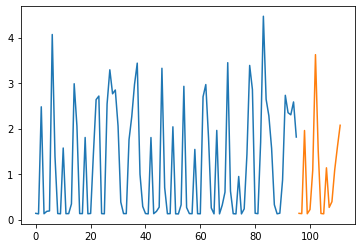

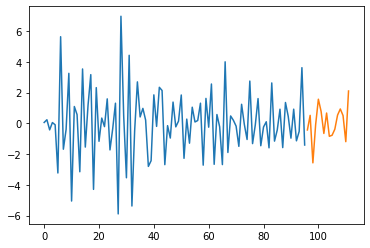

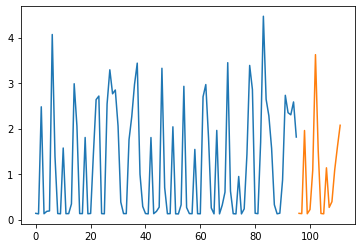

In [254]:
plt.plot(xog)
plt.plot(np.arange(len(xog),len(xog) + yog.shape[1]), yog[-1])
plt.figure()
plt.plot(xt)
plt.plot(np.arange(len(xt),len(xt) + yt.shape[1]), yt[-1])
plt.figure()
plt.plot(xx)
plt.plot(np.arange(len(xx),len(xx) + len(yy)), yy)

In [257]:
np.random.seed(42)
tf.random.set_seed(42)
LSTMBatchNormDrop.train(100,learningRate=0.01,isEarlyStoping=True,batch_size=16,isSaveTensorBoard=True)

|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
Epoch 1/100
4/4 [==============================] - 13s 2s/step - loss: 3.9016 - val_loss: 3.5763
Epoch 2/100
4/4 [==============================] - 0s 136ms/step - loss: 3.8809 - val_loss: 3.5439
Epoch 3/100
4/4 [==============================] - 0s 101ms/step - loss: 3.8413 - val_loss: 3.5112
Epoch 4/100
4/4 [==============================] - 0s 102ms/step - loss: 3.7974 - val_loss: 3.4754
Epoch 5/100
4/4 [==============================] - 0s 106ms/step - loss: 3.7624 - val_loss: 3.4400
Epoch 6/100
4/4 [==============================] - 0s 102ms/step - loss: 3.7286 - val_loss: 3.4084
Epoch 7/100
4/4 [==============================] - 0s 101ms/step - loss: 3.7014 - val_loss: 3.3914
Epoch 8/100
4/4 [==============================] - 0s 123ms/step - loss: 3.7137 - val_loss: 3.4018
Epoch 9/100
4/4 [==============================] - 0s 93ms/step - loss: 3.6805 - val_loss: 3.3692
E

In [14]:
LSTMBatchNormDrop.save()

INFO:tensorflow:Assets written to: Models/WaveNet-112-56-28-16-Batch-56-epoch-200\assets


INFO:tensorflow:Assets written to: Models/WaveNet-112-56-28-16-Batch-56-epoch-200\assets


In [258]:
# import warnings
# warnings.filterwarnings("ignore")
with np.errstate(divide='ignore'):
    x = LSTMBatchNormDrop.testResult(show=True)
pd.DataFrame([np.mean(abs(r)) for r in x][:-2],['predSum','YSum','diff','precent','mse','rmspe','mape']).transpose()

predSum:  0.5386 YSum:  15.6283 diff:  15.0897 precent:  96.5536% 	 mse:  1.5320 rmspe:  4.3246 mape:  274.6151
predSum:  65.8222 YSum:  19.2719 diff: -46.5503 precent: -241.5444% 	 mse:  13.0700 rmspe:  16.3280 mape:  1100.3310
predSum:  77.2191 YSum:  19.7100 diff: -57.5091 precent: -291.7755% 	 mse:  16.9509 rmspe:  16.4211 mape:  1148.5533
predSum: -14.6920 YSum:  10.3196 diff:  25.0116 precent:  242.3702% 	 mse:  3.7793 rmspe:  9.7928 mape:  734.9715
predSum: -20.0957 YSum:  13.4002 diff:  33.4959 precent:  249.9657% 	 mse:  6.4646 rmspe:  12.8742 mape:  925.9213
predSum:  32.0288 YSum:  10.6840 diff: -21.3448 precent: -199.7837% 	 mse:  2.6710 rmspe:  6.7516 mape:  529.5890
predSum:  62.2428 YSum:  17.9344 diff: -44.3084 precent: -247.0582% 	 mse:  11.5767 rmspe:  13.4480 mape:  925.3435
predSum:  67.6315 YSum:  17.7980 diff: -49.8335 precent: -279.9946% 	 mse:  12.2218 rmspe:  10.9938 mape:  710.8959


,predSum,YSum,diff,precent,mse,rmspe,mape
0,42.53384,15.593303,36.642902,231.130729,8.53329,11.366748,793.77756


In [41]:
x = LSTMBatchNormDrop.testResult(show=True)
pd.DataFrame([np.mean(abs(r)) for r in x][:-2],['predSum','YSum','diff','precent','mse','rmspe','mape']).transpose()

predSum:  7.4133 YSum:  12.7608 diff:  5.3475 precent:  41.9055% 	 mse:  0.2800 rmspe:  2.1616 mape:  119.8123
predSum:  6.0084 YSum:  15.6283 diff:  9.6199 precent:  61.5546% 	 mse:  0.8726 rmspe:  2.0725 mape:  119.7039
predSum:  3.3207 YSum:  16.4401 diff:  13.1194 precent:  79.8014% 	 mse:  1.2558 rmspe:  3.4511 mape:  199.9184
predSum:  33.6222 YSum:  19.2720 diff: -14.3503 precent: -74.4620% 	 mse:  4.5028 rmspe:  10.2163 mape:  412.9053
predSum:  11.0200 YSum:  13.4080 diff:  2.3879 precent:  17.8099% 	 mse:  0.2756 rmspe:  1.3728 mape:  76.0424
predSum:  18.3612 YSum:  19.7100 diff:  1.3489 precent:  6.8436% 	 mse:  0.3775 rmspe:  1.2005 mape:  67.2576
predSum:  9.1172 YSum:  14.2007 diff:  5.0835 precent:  35.7975% 	 mse:  0.4737 rmspe:  1.9162 mape:  106.2394
predSum:  6.3513 YSum:  10.3196 diff:  3.9683 precent:  38.4537% 	 mse:  0.2801 rmspe:  2.6869 mape:  159.8547
predSum:  14.1514 YSum:  16.9517 diff:  2.8003 precent:  16.5192% 	 mse:  0.5281 rmspe:  0.8517 mape:  59.207

,predSum,YSum,diff,precent,mse,rmspe,mape
0,11.105278,15.348475,8.607155,56.546233,1.303633,2.93293,159.655101


In [15]:
LSTMBatchNormDrop.model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 112)         51072     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 56)          37856     
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 28)          9520      
_________________________________________________________________
time_distributed (TimeDistri (None, None, 16)          464       
Total params: 98,912
Trainable params: 98,912
Non-trainable params: 0
_________________________________________________________________


In [65]:
9416*12

112992

0
1
2
3
4
5
6
7


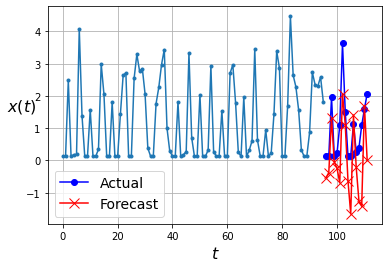

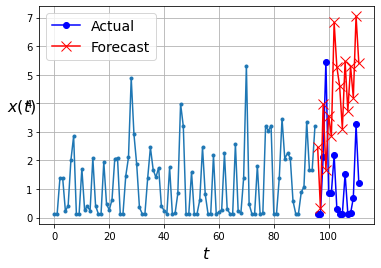

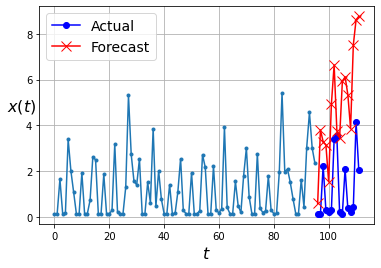

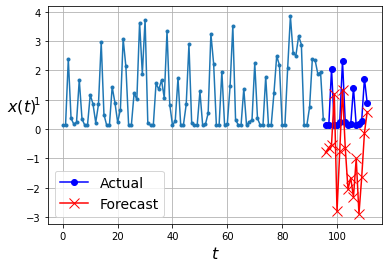

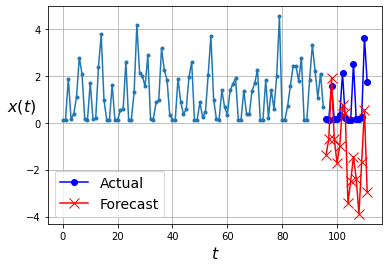

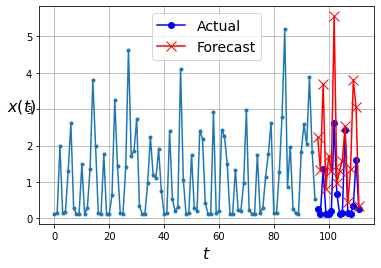

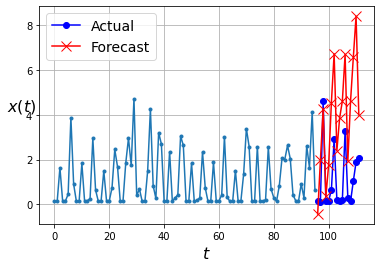

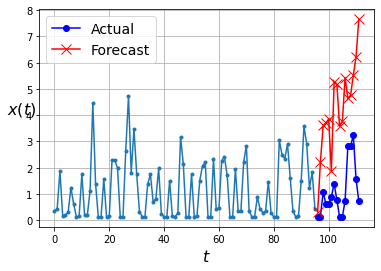

<Figure size 432x288 with 0 Axes>

In [259]:
LSTMBatchNormDrop.test(batchStart=0,plotsCount=8)

In [167]:
import winsound

#sumIn = [60,80,100,120,140,160,180,200,220,240,260,280,300]
sumIn = range(60,12*60,15)
results = []
for i,sumInN in enumerate(sumIn):
    np.random.seed(42)
    tf.random.set_seed(42)
    LPG = MyLoader(
        files=[f_data_path + "LPG-Profile-0.feather"],
        batchSize=int(1440/sumInN)*7,
        timeSeriesLables=['energy'],
        otherDataLabels=[],
        splitFun=OverlapingBatchWithNLen,
        sumInN=sumInN,
        asSum=True,
        asDiff=False,
        pred_n=int(2880 / sumInN),
        lable="LPG16")

    LSTM = MyModel(
        batchSize=int(1440/sumInN)*7,
        loader=LPG,
        lable="ConvGRUEarlyStop",
        createModel=createConvGRUTimeDist,
        modelArgs=[int(2880 / sumInN),int(2880 / sumInN / 4)],
        modleDims=[int(1440/sumInN)*7*2,int(1440/sumInN)*4,int(2880 / sumInN)*3,int(2880 / sumInN)],
        predDataFun=predDataConv
    )

    LSTM.train(400,verbose=0,isSaveTensorBoard=False,isEarlyStoping=True)
    results.append(LSTM.testResult())
    print(f"Testing: {sumInN}")
    progres_bar(i + 1, len(sumIn))

winsound.Beep(1000, 400)


|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
Done Fiting.
Testing: 60
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
Done Fiting.
Testing: 75
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
Done Fiting.
Testing: 90
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
Done Fiting.
Testing: 105
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
Done Fiting.
Testing: 120
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
Done Fiting.
Testing: 135
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
Done Fiting.
Testing: 150
|███████████████████████████████████████████

In [168]:
rr = [[np.mean(np.abs(r[i])) for i in range(len(r)-2)]for r in results]
rr = np.array(rr)

In [169]:
df = pd.DataFrame(np.abs(rr))
df.columns = ['pred sum', 'Y sum', 'diff', '%', 'mse', 'rmspe', 'mape']
df['sumIn'] = sumIn
df.to_csv("Results/Test_SumInBestTime_BatchScale_ModelDimsAuto_EarlyStopModel_2xmoreNeurons_Diff_seed42_60-720_ConvGru_TimeDistrib.csv")
df

,pred sum,Y sum,diff,%,mse,rmspe,mape,sumIn
0,13.108234,14.868213,2.319676,14.199994,0.105864,0.841857,60.735568,60
1,19.159190,13.586494,5.572696,44.660734,0.196410,2.258998,166.576335,75
2,14.535124,14.868213,2.666389,17.849090,0.172540,0.907760,62.024444,90
3,5.811628,18.662450,12.850823,67.879092,0.782963,0.802580,69.531642,105
4,14.936648,14.868213,2.564233,17.599438,0.268050,0.875283,64.767217,120
5,17.960218,16.848298,2.803270,16.523926,0.683828,1.477441,101.851330,135
6,18.697066,17.279369,2.926855,18.680367,0.715676,1.365048,97.188714,150
7,15.041026,16.700079,6.785056,36.313888,1.484747,1.340503,92.360515,165
8,14.027105,14.868213,2.365553,15.224880,0.495611,0.550201,40.185934,180
9,16.704476,18.349377,3.995083,21.468041,1.115651,1.049154,80.271316,195


In [134]:
pickle.dump(results,open("Results/TestTest_SumInBestTime_BatchScale_ModelDimsAuto_EarlyStopModel_2xmoreNeurons_Diff_seed42_60-720_ConvGru_TimeDistrib.dat", "wb"))

In [56]:
res2 = pickle.load(open("Results/Test_SumInBestTime_BatchScale_ModelDimsAuto_EarlyStop2.dat", "rb"))

In [135]:
df.describe()

,pred sum,Y sum,diff,%,mse,rmspe,mape,sumIn
count,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000
mean,15.690806,16.054395,3.730705,23.599674,3.273871,0.919642,68.335676,382.500000
std,2.058360,1.754833,0.912323,5.812920,2.689484,0.412905,27.936470,192.678489
min,9.545694,13.036545,2.317807,13.821583,0.144054,0.391628,30.758292,60.000000
25%,14.577220,14.868213,3.036023,19.891382,1.072600,0.637844,51.657387,221.250000
50%,15.982593,16.095388,3.683588,23.368475,2.679642,0.793581,60.463131,382.500000
75%,17.138023,17.049122,4.100511,25.509546,4.752659,1.073464,76.813474,543.750000
max,19.052125,20.380038,5.867410,44.276663,10.693435,2.383435,168.273269,705.000000


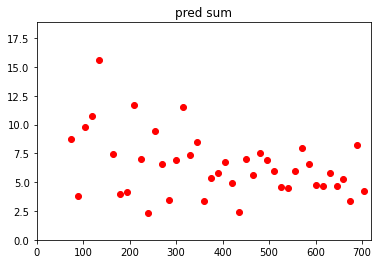

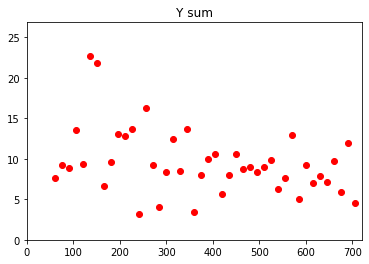

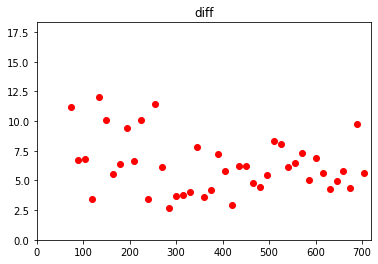

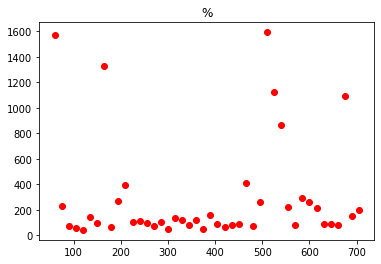

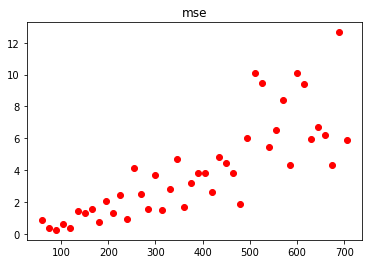

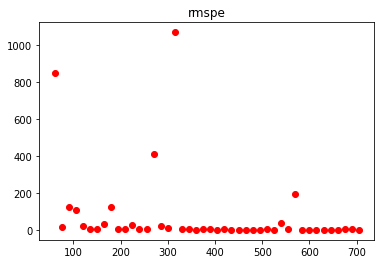

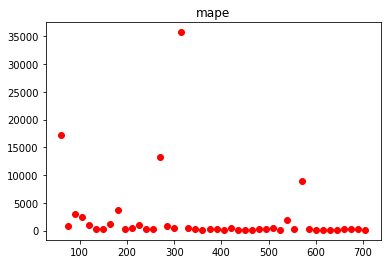

<Figure size 432x288 with 0 Axes>

In [143]:

cols = ['pred sum', 'Y sum', 'diff', '%', 'mse', 'rmspe', 'mape']
for i,col in enumerate(cols):
    plt.plot(sumIn,df[col],"ro")
    if i < 3:
        plt.axis([0, 720
        , 0, df[col].median()*3])
    plt.title(col)
    plt.figure()

In [170]:
y = [r[7] for r in results]
pred = [r[8] for r in results]

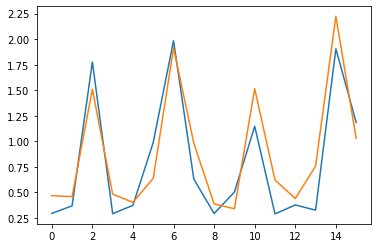

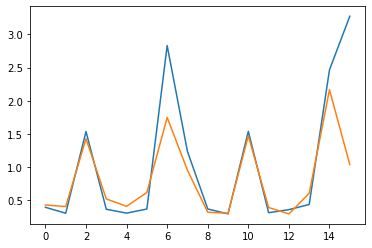

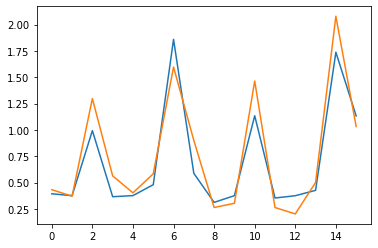

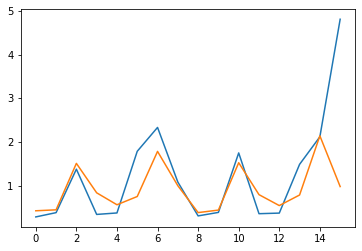

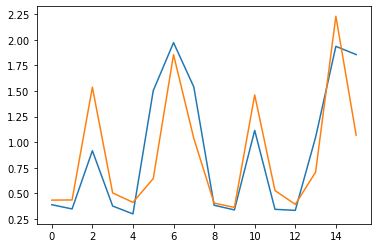

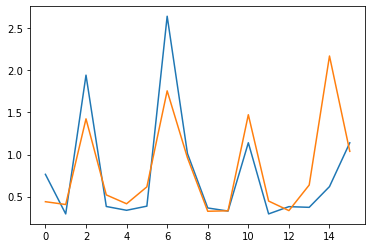

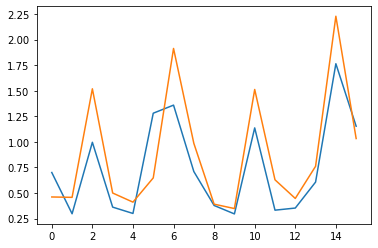

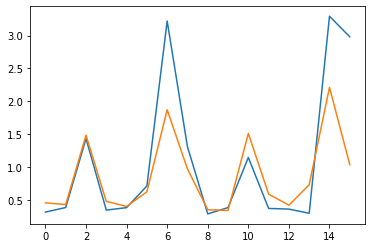

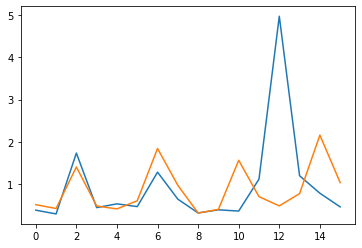

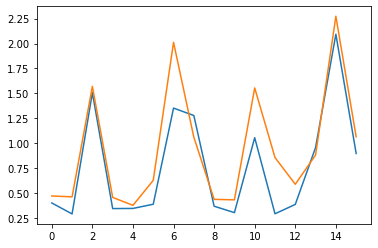

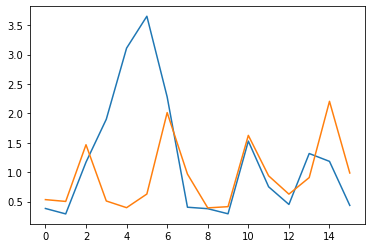

<Figure size 432x288 with 0 Axes>

In [173]:
s = 8

for a,b in zip(y[s],pred[s]):
    plt.plot(a)
    plt.plot(b)
    plt.figure()